In [1]:
from sklearn.decomposition import NMF

from keras.models import Model
import keras.models
import keras.layers as layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from keras import backend as K

import copy
import cnn_analyzer as cnna
import cnn_builder as cbuild
import config
import csv
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import importlib
import itertools
from math import sqrt, log, pi, exp
import matplotlib.pyplot as plt
from numba import jit, njit, prange, vectorize, guvectorize
from numpy import matmul, diag
import numpy as np
import operator
import os
from os.path import *
import pandas as pd
import random
import scipy
import time
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
C = config.Config()

In [3]:
model = keras.models.load_model(os.path.join(C.model_dir, "model_no_pad.hdf5"))

In [ ]:
model = keras.models.load_model(os.path.join(C.model_dir, "models_305.hdf5")) #models_305

In [4]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model_frozen.layers[1:]])
layer_dict

In [82]:
init_img = orig_data_dict['hcc'][0][0]

In [117]:
channel_ixs = list(range(2,4))

In [ ]:
cnna.visualize_layer(model_frozen, 'conv3d_11', "D:\\filters", channel_ixs)#, init_img=init_img)

In [16]:
model_trunc = cbuild.build_pretrain_model(model, last_layer=-2)

In [5]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()
filters_by_cls = {cls: model_dense_outputs.predict(orig_data_dict[cls][0], verbose=False) for cls in C.classes_to_include}
fig = cnna.tsne(filters_by_cls)
fig.show()

In [224]:
len(hf.flatten([list(feature_sheet["evidence1"+cls].dropna().values) for cls in C.classes_to_include]))

137

model_conv1 = cbuild.build_pretrain_model(model, last_layer=-6, add_activ=True)
model_conv2 = cbuild.build_pretrain_model(model, last_layer=-5, add_activ=True)
model_conv3 = cbuild.build_pretrain_model(model, last_layer=-4, add_activ=True)
model_dense = cbuild.build_pretrain_model(model, last_layer=-3, add_activ=True)

In [304]:
cls = 'cyst'
cls_img_set = orig_data_dict[cls][0]
cls_activ_set = model_conv3.predict(cls_img_set)

nmf = NMF(4)
cls_activ_set_xform = nmf.fit_transform(cls_activ_set.mean((1,2,3)))

nmf_comps = [nmf.components_[i] * (nmf.components_[i] > np.median(nmf.components_,0)*2) for i in range(4)]

In [187]:
importlib.reload(cnna)

<module 'cnn_analyzer' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_analyzer.py'>

In [ ]:
cnna.visualize_layer_weighted(model_frozen, 'conv3d_11', "D:\\filters", K.constant(nmf_comps[0]))

In [277]:
activs0 = cls_activ_set[:,:,:,:,nmf_comps[1] > 0]
activ_map0 = activs0.mean(4)

In [278]:
activ_map0, _ = tr.rescale_img(np.transpose(activ_map0, (1,2,3,0)), cls_img_set[img_id].shape[:3])
activ_map0 = np.transpose(activ_map0, (3,0,1,2))

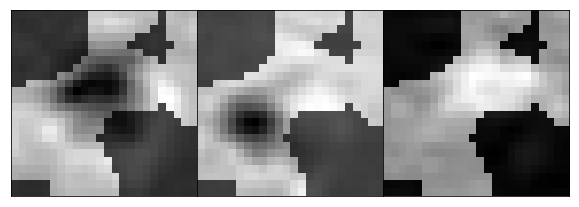

In [282]:
img_id = 1
alpha = 1.
overlaid_img = cls_img_set[img_id] - np.amin(cls_img_set[img_id])
overlaid_img = np.stack([((activ_map0[img_id] > np.mean(activ_map0[img_id])*alpha)+.5) * overlaid_img[:,:,:,i] for i in range(3)], 3)
hf.draw_slices(overlaid_img)

In [ ]:
hf.draw_slices(cls_img_set[img_id])

In [5]:
def kl_div(m1, sig1, m2, sig2, one_sided="none"):
    #returns kl(p,q) where p~N(m1,s1), q~N(m2,s2)
    ret = np.log(sig2/sig1) + (sig1**2+(m1-m2)**2)/(2*sig2**2) - .5
    if one_sided=="less":
        return ret * (m1 < m2)
    elif one_sided=="greater":
        return ret * (m1 > m2)
    else:
        return ret

In [13]:
importlib.reload(cbuild)

<module 'cnn_builder' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_builder.py'>

In [4]:
model_conv1_pre = cbuild.build_pretrain_model(model, padding=['same','same'], last_layer=-6)#, add_activ=True)
model_conv2_pre = cbuild.build_pretrain_model(model, padding=['same','same'], last_layer=-5)#, add_activ=True)
model_conv3_pre = cbuild.build_pretrain_model(model, padding=['same','same'], last_layer=-4)#, add_activ=True)
model_dense_pre = cbuild.build_pretrain_model(model, padding=['same','same'], last_layer=-3)#, add_activ=True)

In [6]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()

features_by_cls, feat_count = cnna.collect_features()
feat_count.pop("central scar")
all_features = sorted(list(feat_count.keys()))
cls_features = {f: [c for c in C.classes_to_include if f in features_by_cls[c]] for f in all_features}

Z_features = cnna.get_annotated_files(features_by_cls)
Z_features.pop("central scar")

['12572068_0', '13092836_1', 'E103354630_0', 'E105921537_0', 'E106010098_0']

In [7]:
import dr_methods as drm
voi_df = drm.get_voi_dfs()[0]

In [126]:
Z = np.concatenate([orig_data_dict[cls][1] for cls in C.classes_to_include], 0)

all_conv2_ch = np.empty([0,128])
all_conv3_ch = np.empty([0,128])

aug_factor = 10
for img_id in range(len(Z)):
    voi_row = voi_df.loc[Z[img_id]]
    for aug_id in range(aug_factor):
        img = np.load(os.path.join(C.aug_dir, voi_row['cls'], "%s_%d.npy" % (Z[img_id], aug_id)))
        activ = model_conv2_pre.predict(np.expand_dims(img, 0))
        all_conv2_ch = np.concatenate([all_conv2_ch, activ.mean(axis=(1,2,3))], axis=0)
        activ = model_conv3_pre.predict(np.expand_dims(img, 0))
        all_conv3_ch = np.concatenate([all_conv3_ch, activ.mean(axis=(1,2,3))], axis=0)

In [8]:
print(list(zip(range(len(all_features)), all_features)))

[(0, 'arterial enhancement'), (1, 'continuous enhancing rim'), (2, 'delayed isointensity'), (3, 'heterogeneous'), (4, 'hyperintense mass on delayed phase'), (5, 'hypointense without enhancement'), (6, 'infiltrative'), (7, 'lobulated margins'), (8, 'nodular or discontinuous enhancement'), (9, 'progressive centripetal filling'), (10, 'progressive or concentric enhancement'), (11, 'regular spherical hypointense mass'), (12, 'thin well-defined walls'), (13, 'venous washout')]


In [11]:
relevant_features = [1,10,11] #colorectal#[0,1,3,13] #hcc, [3,7,10] cholangio
img_dir = "D:\\feature_analysis\\crc"
if not exists(img_dir):
    os.makedirs(img_dir)

num_rel_f = len(relevant_features)

D = np.empty((8,8,4))
for x in range(D.shape[0]):
    for y in range(D.shape[1]):
        for z in range(D.shape[2]):
            D[x,y,z] = (D.shape[0]-.5-x)**2 + (D.shape[1]-.5-y)**2 + 4*(D.shape[2]-.5-z)**2

def get_shells(activ, D):
    shell4 = activ[0, D > 85, :].mean(axis=0)
    shell3 = activ[0, (D <= 85) & (D > 62), :].mean(axis=0)
    shell2 = activ[0, (D <= 62) & (D > 39), :].mean(axis=0)
    shell1 = activ[0, D <= 39, :].mean(axis=0)
    return np.expand_dims(np.stack([shell1, shell2, shell3, shell4], 0), 0)

In [ ]:
feature_conv1_ch = {f:np.empty([0,12,12,6,128]) for f in all_features}
#feature_conv2_ch = {f:np.empty([0,12,12,6,128]) for f in all_features}
#feature_conv3_ch = {f:np.empty([0,12,12,6,128]) for f in all_features}
#feature_conv3_sh = {f:np.empty([0,4,128]) for f in all_features}
aug_factor = 80
for f_ix in relevant_features:
    f = all_features[f_ix]
    Z_f = Z_features[f]
    for img_id in range(len(Z_f)):
        voi_row = voi_df.loc[Z_f[img_id]]
        for aug_id in range(aug_factor):
            img = np.load(os.path.join(C.aug_dir, voi_row['cls'], "%s_%d.npy" % (Z_f[img_id], aug_id)))
            activ = model_conv1_pre.predict(np.expand_dims(img, 0))
            feature_conv1_ch[f] = np.concatenate([feature_conv1_ch[f], activ], axis=0)
            #activ = model_conv2_pre.predict(np.expand_dims(img, 0))
            #feature_conv2_ch[f] = np.concatenate([feature_conv2_ch[f], activ], axis=0)
            #activ = model_conv3_pre.predict(np.expand_dims(img, 0))
            #feature_conv3_ch[f] = np.concatenate([feature_conv3_ch[f], activ], axis=0)
            #feature_conv3_sh[f] = np.concatenate([feature_conv3_sh[f], get_shells(activ, D)], axis=0)

In [ ]:
conv1_ch_plus = copy.deepcopy(feature_conv1_ch)
for i, f_ix in enumerate(relevant_features):
    f = all_features[f_ix]
    conv1_ch_plus[f][conv1_ch_plus[f] < 0] = 0
    conv1_ch_plus[f] = conv1_ch_plus[f].mean(0)

In [ ]:
conv2_ch_plus = copy.deepcopy(feature_conv2_ch)
for i, f_ix in enumerate(relevant_features):
    f = all_features[f_ix]
    conv2_ch_plus[f][conv2_ch_plus[f] < 0] = 0
    conv2_ch_plus[f] = conv2_ch_plus[f].mean(0)

In [ ]:
conv3_ch_plus = copy.deepcopy(feature_conv3_ch)
for i, f_ix in enumerate(relevant_features):
    f = all_features[f_ix]
    conv3_ch_plus[f][conv3_ch_plus[f] < 0] = 0
    conv3_ch_plus[f] = conv3_ch_plus[f].mean(0)

In [194]:
conv3_sh_plus = {}
for i, f_ix in enumerate(relevant_features):
    f = all_features[f_ix]
    activ = conv3_ch_plus[f]
    shell4 = activ[D > 85, :].mean(0)
    shell3 = activ[(D <= 85) & (D > 62), :].mean(0)
    shell2 = activ[(D <= 62) & (D > 39), :].mean(0)
    shell1 = activ[D <= 39, :].mean(0)
    conv3_sh_plus[f] = np.stack([shell1, shell2, shell3, shell4], 0)

In [ ]:
feature_avgs = np.zeros((num_rel_f,128))
for i, f_ix in enumerate(relevant_features):
    f = all_features[f_ix]
    feature_avgs[i] = conv1_ch_plus[f].mean((0,1,2))
    #feature_avgs[i] = conv3_ch_plus[f].mean((0,1,2))
    
channel_separations = np.empty((num_rel_f,128)) # separation between channel mean activations for the relevant features
for i in range(num_rel_f):
    channel_separations[i] = (np.amax(feature_avgs, 0) - feature_avgs[i]) / np.mean(feature_avgs, 0)

channel_separations *= 10

W = np.zeros((num_rel_f,128))
for ch_ix in range(128):
    #f_ix = list(channel_separations[:,ch_ix]).index(0)
    #W[f_ix,ch_ix] = channel_separations[:,ch_ix].mean()
    W[:,ch_ix] = np.median(channel_separations[:,ch_ix]) - channel_separations[:,ch_ix]
    
W[W < 0] = 0

feature_avgs = np.zeros((4,128))
for i, f_ix in enumerate(relevant_features):
    f = all_features[f_ix]
    feature_avgs[i] = conv3_sh_plus[f].mean(0).max(0)
    
channel_separations = np.empty((4,128))
for i in range(4):
    channel_separations[i] = np.amax(feature_avgs, 0) - feature_avgs[i]

active_neuron_ixs = np.where(h_ic_rot[0] > 0)

num_active_neurons = active_neuron_ixs[0].size

H = h_ic[h_ic > 0]
np.matmul(H, W)

In [9]:
@njit
def get_spatial_overlap(w, f_c3_ch):
    relevant_features = ch_weights.keys()
    
    ch_weights2 = np.zeros(num_rel_f,128)
    for ch in range(128):
        f_c3_ch[:,:,:,:,ch] = (f_c3_ch[:,:,:,:,ch] - np.mean(f_c3_ch[:,:,:,:,ch]))# / np.std(f_c3_ch[:,:,:,:,ch])
        
        if ch_weights[ch] > 0:
            w = np.zeros(f_c3_ch.shape[:4])
            for i in range(128):
                if ch_weights[i] > 0:
                    w += ch_weights[i] * f_c3_ch[:,:,:,:,i]
            w = w / np.sum(ch_weights)
            ch_weights2[ch] = np.sum(f_c3_ch[:,:,:,:,ch] * w)
            
    return ch_weights2

In [ ]:
cls = 'colorectal'
cls_img_set = orig_data_dict[cls][0]
#cls_activ_set = model_conv3_pre.predict(cls_img_set)

img_id = 0
x = cls_img_set[img_id]

In [ ]:
#h_ic = [model_conv1_pre.predict(np.expand_dims(np.rot90(x,r),0))[0] for r in range(4)]
#h_ic = [model_conv2_pre.predict(np.expand_dims(np.rot90(x,r),0))[0] for r in range(4)]
h_ic = [model_conv3_pre.predict(np.expand_dims(np.rot90(x,r),0))[0] for r in range(4)]

h_ic_plus = copy.deepcopy(h_ic)
for r in range(4):
    h_ic_plus[r][h_ic_plus[r] < 0] = 0

h_ic_rot = [np.rot90(h_ic_plus[r], 4-r) for r in range(4)] #rotated back into original frame

In [ ]:
h_ic_rot = np.array(h_ic_rot)
test_neurons = h_ic_rot.mean(0)

H = [h_ic_rot[a][active_neuron_ixs] for a in range(4)]

np.sum(3*np.matmul(H[0], W) - np.matmul(H[1], W) - np.matmul(H[2], W) - np.matmul(H[3], W))

h_ca = {f_ix: feature_conv3_ch[all_features[f_ix]].mean((0,1,2,3)) for f_ix in relevant_features}
h_ca_plus = {f_ix: feature_conv3_ch[all_features[f_ix]][feature_conv3_ch[all_features[f_ix]] > 0].mean((0,1,2,3)) for f_ix in relevant_features}

tmp = np.tile(h_ca[f_ix], list(h_ic.shape[:3])+[1])

for f_ix in relevant_features:
    w_ica[f_ix] = h_ic_plus / (np.abs(h_ic_plus - h_ca[f_ix]) + 1e-5)

x = cls_img_set[img_id]
test_neurons = model_conv3_pre.predict(np.expand_dims(x,0))[0]
test_neurons[test_neurons < 0] = 0

In [152]:
m = all_conv2_ch.mean(0)
s = all_conv2_ch.std(0)
ch_weights = np.empty((num_rel_f, 128))
for f_num, f_ix in enumerate(relevant_features):
    f_c3_ch = feature_conv2_ch[all_features[f_ix]]
    avg_f_conv3_ch = f_c3_ch.mean((1,2,3))
    f_m = avg_f_conv3_ch.mean(0)
    f_s = avg_f_conv3_ch.std(0)

    ch_weights[f_num] = np.log(kl_div(m, s, f_m, f_s, 'less')+1) #kl_div(m, s, f_m, f_s, 'less')

img_id = 0
z = orig_data_dict[cls][1][img_id]

ch_weights2 = get_spatial_overlap(ch_weights, feature_conv3_ch, z)
ch_weights2[ch_weights2 < np.median(ch_weights2) / 2] = 0 #np.median(ch_weights2) / 2
ch_weights[all_features[f_ix]] *= ch_weights2
ch_weights[all_features[f_ix]] /= np.mean(ch_weights[all_features[f_ix]])

In [ ]:
def get_saliency_map(W, test_neurons, num_rel_f):
    sal_map = np.zeros((num_rel_f, *test_neurons.shape[:3]))
    for f_num in range(num_rel_f):
        for ch_ix in range(test_neurons.shape[-1]):
            sal_map[f_num] += W[f_num, ch_ix] * test_neurons[:,:,:,ch_ix]
        sal_map[f_num] /= np.sum(W[f_num])
        
    #for f_num in range(num_rel_f):
    #    for spatial_ix in np.ndindex(test_neurons.shape[:-1]):
    #        sal_map[f_num, spatial_ix] = sal_map[f_num, spatial_ix]**2 / sal_map[:, spatial_ix].sum()
            
    return sal_map

In [147]:
test_neurons = h_ic_rot[0]

In [ ]:
z = orig_data_dict[cls][1][img_id]
layer_type = 'conv1'
#layer_type = 'conv3'
#for f_num, f_ix in enumerate(relevant_features):
sal_map = get_saliency_map(W, test_neurons, num_rel_f)
for f_num in range(num_rel_f):
    sal_map_f = sal_map[f_num]
    if False:
        w = np.zeros(test_neurons.shape[:3])
        for ch_ix in range(128):
            if W[f_num, ch_ix] > 0:
                w += W[f_num, ch_ix] * test_neurons[:,:,:,ch_ix]
        sal_map_f = w / np.sum(W[f_num])
        #sal_map_f0, _ = tr.rescale_img(sal_map_f0, x.shape[:3])
        
    sal_map_f = tr.scale3d(sal_map_f, (2,2,2))

    #for img_id in range(len(cls_img_set)):
    alpha = 1
    overlaid_img = x - np.amin(x)
    overlaid_img = np.stack([((sal_map_f > np.mean(sal_map_f[sal_map_f > 0])*alpha)+.3) * overlaid_img[:,:,:,i] for i in range(3)], 3)
    hf.draw_slices(overlaid_img[:,::-1,:], save_path=img_dir+"\\%s %s (%s).png" % (layer_type, z, all_features[relevant_features[f_num]]))